In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
df = pd.read_parquet('../Dataframes/df.parquet.gzip')

In [3]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6087,1.6104,1.5879,1.5927,0.0,1.595925,16.326531,16.326531,16.326531,...,1.61380,1.59660,1.605200,1.59915,141.857175,183.609406,224.795834,47.024049,-580.628944,-558.700648
30,14/2/2000,1.5927,1.5971,1.5860,1.5873,1.0,1.589425,4.166667,4.153355,4.153355,...,1.60375,1.58695,1.595350,1.59155,123.669380,146.514411,172.781294,252.413836,-379.571709,-528.186512
31,15/2/2000,1.5873,1.5976,1.5851,1.5960,1.0,1.593675,43.083004,33.956386,33.850932,...,1.59735,1.58555,1.591450,1.59135,191.458027,144.278393,157.105210,266.956749,-81.647095,-483.338404
32,16/2/2000,1.5960,1.6100,1.5946,1.6072,1.0,1.604750,88.755020,87.351779,68.847352,...,1.60380,1.58985,1.596825,1.60230,-107.547908,37.248993,132.796436,273.808202,136.045358,-474.973133
33,17/2/2000,1.6072,1.6138,1.6027,1.6083,0.0,1.608275,80.836237,80.836237,80.836237,...,1.61190,1.59865,1.605275,1.60825,-68.693550,-67.738396,101.820193,273.911976,330.800262,-430.288438


In [4]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [4]:
df.drop(columns=['delta'],inplace=True)

In [5]:
df.head()

,date,open,high,low,close,wclose,so_3,so_4,so_5,so_8,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6087,1.6104,1.5879,1.5927,1.595925,16.326531,16.326531,16.326531,27.218935,...,1.61380,1.59660,1.605200,1.59915,141.857175,183.609406,224.795834,47.024049,-580.628944,-558.700648
30,14/2/2000,1.5927,1.5971,1.5860,1.5873,1.589425,4.166667,4.153355,4.153355,11.242604,...,1.60375,1.58695,1.595350,1.59155,123.669380,146.514411,172.781294,252.413836,-379.571709,-528.186512
31,15/2/2000,1.5873,1.5976,1.5851,1.5960,1.593675,43.083004,33.956386,33.850932,36.982249,...,1.59735,1.58555,1.591450,1.59135,191.458027,144.278393,157.105210,266.956749,-81.647095,-483.338404
32,16/2/2000,1.5960,1.6100,1.5946,1.6072,1.604750,88.755020,87.351779,68.847352,68.633540,...,1.60380,1.58985,1.596825,1.60230,-107.547908,37.248993,132.796436,273.808202,136.045358,-474.973133
33,17/2/2000,1.6072,1.6138,1.6027,1.6083,1.608275,80.836237,80.836237,80.836237,72.049689,...,1.61190,1.59865,1.605275,1.60825,-68.693550,-67.738396,101.820193,273.911976,330.800262,-430.288438


### Change the normalization to be (0, 1)

In [7]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [8]:
input_features

array([[0.44759583, 0.44281622, 0.44222977, ..., 0.61738803, 0.28172206,
        0.20939202],
       [0.42986927, 0.42816219, 0.44014894, ..., 0.68964772, 0.37258541,
        0.22458155],
       [0.42388655, 0.42871309, 0.43916329, ..., 0.69476417, 0.50722582,
        0.24690633],
       ...,
       [0.04232218, 0.04605553, 0.06275326, ..., 0.61691424, 0.63203772,
        0.62162521],
       [0.04874806, 0.04561481, 0.05552513, ..., 0.70709414, 0.63798728,
        0.62209126],
       [0.03390206, 0.03261349, 0.05059687, ..., 0.66828302, 0.65686441,
        0.62213368]])

In [9]:
input_data.shape

(5120, 33)

In [10]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [11]:
input_data

array([[0.44759583, 0.44281622, 0.44222977, ..., 0.61738803, 0.28172206,
        0.20939202],
       [0.42986927, 0.42816219, 0.44014894, ..., 0.68964772, 0.37258541,
        0.22458155],
       [0.42388655, 0.42871309, 0.43916329, ..., 0.69476417, 0.50722582,
        0.24690633],
       ...,
       [0.04232218, 0.04605553, 0.06275326, ..., 0.61691424, 0.63203772,
        0.62162521],
       [0.04874806, 0.04561481, 0.05552513, ..., 0.70709414, 0.63798728,
        0.62209126],
       [0.03390206, 0.03261349, 0.05059687, ..., 0.66828302, 0.65686441,
        0.62213368]])

In [12]:
input_data[[0],1:]

array([[0.44281622, 0.44222977, 0.42986927, 0.43448849, 0.34793734,
        0.3515838 , 0.35583121, 0.41457158, 0.41260087, 0.38039569,
        0.43195315, 0.43195315, 0.41457158, 0.41260087, 0.38039569,
        0.44437551, 0.42939113, 0.38444778, 0.407909  , 0.46295867,
        0.52271439, 0.33917658, 0.44676144, 0.44447556, 0.44459004,
        0.43930315, 0.44478368, 0.61087005, 0.64403346, 0.61738803,
        0.28172206, 0.20939202]])

In [13]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [14]:
X

array([[[[0.44281622, 0.44222977, 0.42986927, ..., 0.61738803,
          0.28172206, 0.20939202]],

        [[0.42816219, 0.44014894, 0.42388655, ..., 0.68964772,
          0.37258541, 0.22458155]],

        [[0.42871309, 0.43916329, 0.43352537, ..., 0.69476417,
          0.50722582, 0.24690633]],

        ...,

        [[0.41394888, 0.42788304, 0.41236428, ..., 0.51574587,
          0.45447428, 0.37550568]],

        [[0.41295725, 0.42952579, 0.41856858, ..., 0.59300695,
          0.45093511, 0.37489426]],

        [[0.41218599, 0.43138758, 0.41557722, ..., 0.64002525,
          0.44483384, 0.37407491]]],


       [[[0.42816219, 0.44014894, 0.42388655, ..., 0.68964772,
          0.37258541, 0.22458155]],

        [[0.42871309, 0.43916329, 0.43352537, ..., 0.69476417,
          0.50722582, 0.24690633]],

        [[0.4423755 , 0.44956741, 0.44593397, ..., 0.69717463,
          0.60560709, 0.25107045]],

        ...,

        [[0.41295725, 0.42952579, 0.41856858, ..., 0.59300695,
       

In [15]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4563, 50, 32)

In [16]:
file = "./Models/" + "Model" + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    # model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4563/4563 [==============================] - 10s 2ms/step - loss: 0.0077
Epoch 2/5
4563/4563 [==============================] - 8s 2ms/step - loss: 4.4221e-04
Epoch 3/5
4563/4563 [==============================] - 9s 2ms/step - loss: 3.34

In [17]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [18]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.3205, 1.3159, 1.3188, 1.3198, 1.3134, 1.3262, 1.3161, 1.312 ,
       1.3208, 1.3283, 1.3245, 1.3059, 1.3076, 1.3171, 1.3166, 1.3116,
       1.3146, 1.319 , 1.3116, 1.3165, 1.3172, 1.3195, 1.3206, 1.3235,
       1.3239, 1.3325, 1.3309, 1.333 , 1.3318, 1.3339, 1.3409, 1.3525,
       1.3479, 1.348 , 1.3443, 1.3393, 1.3474, 1.3381, 1.3341, 1.3318,
       1.342 , 1.3431, 1.3327, 1.3383, 1.3385, 1.3376, 1.3386, 1.3364,
       1.3371, 1.3374, 1.3399, 1.3443, 1.3513, 1.3503, 1.359 , 1.3516,
       1.3551, 1.3571, 1.3568, 1.354 , 1.3507, 1.3538, 1.373 , 1.3792,
       1.3792, 1.3831, 1.3894, 1.3871, 1.3987, 1.4   , 1.4242, 1.4142,
       1.4163, 1.4074, 1.4147, 1.4191, 1.4265, 1.4131, 1.3959, 1.3949,
       1.3881, 1.3913, 1.3815, 1.3837, 1.3894, 1.3999, 1.4099, 1.4025,
       1.4   , 1.3996, 1.3918, 1.3956, 1.3974, 1.3968, 1.3909, 1.376 ,
       1.3776, 1.3778, 1.3849, 1.3888, 1.3896, 1.381 , 1.3851, 1.3906,
       1.3962, 1.3962, 1.3937, 1.3941, 1.4024, 1.3998, 1.4141, 1.4096,
      

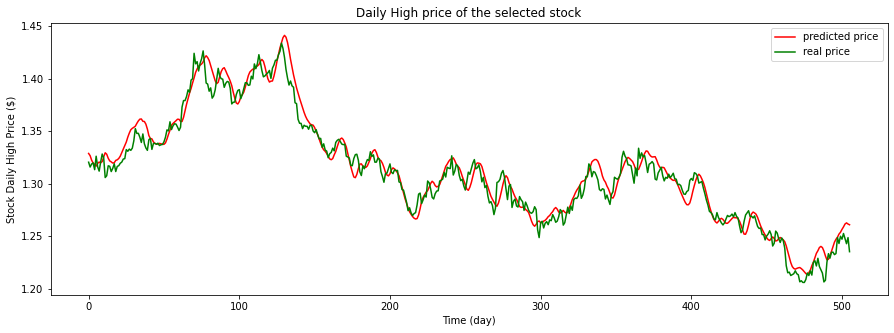

In [19]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [20]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [21]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.3205,1.328845,NaN,NaN
1,1.3159,1.326710,1.328845,-0.002135
2,1.3188,1.322458,1.326710,-0.004252
3,1.3198,1.319669,1.322458,-0.002789
4,1.3134,1.318575,1.319669,-0.001094
...,...,...,...,...
501,1.2526,1.258907,1.256556,0.002351
502,1.2476,1.261635,1.258907,0.002728
503,1.2429,1.262721,1.261635,0.001086
504,1.2487,1.261628,1.262721,-0.001092


In [22]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [23]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.3205,1.328845,NaN,NaN,NaN,1.317050,NaN
1,1.3159,1.326710,1.328845,-0.002135,-0.324559,1.316625,-0.000323
2,1.3188,1.322458,1.326710,-0.004252,-0.644774,1.319525,0.002203
3,1.3198,1.319669,1.322458,-0.002789,-0.422689,1.315225,-0.003259
4,1.3134,1.318575,1.319669,-0.001094,-0.166544,1.322650,0.005645
5,1.3262,1.316787,1.318575,-0.001788,-0.269673,1.318700,-0.002986
6,1.3161,1.319455,1.316787,0.002668,0.405421,1.311800,-0.005232
7,1.3120,1.320626,1.319455,0.001172,0.178591,1.318425,0.005050
8,1.3208,1.319939,1.320626,-0.000687,-0.104055,1.326125,0.005840
9,1.3283,1.321086,1.319939,0.001146,0.172584,1.326300,0.000132


In [24]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

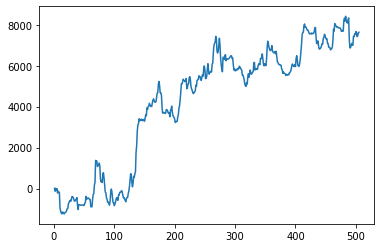

In [25]:
plt.plot(frame['daily_pnl'].cumsum())
plt.show()

In [26]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

1.210530097409292

In [27]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.0699588477366255